In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time
import os
from tqdm import tqdm
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values[SMILES_COLUMN]]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

In [3]:

FILENAME = "test_predictions.csv"

SMILES_COLUMN = 'smiles'
ERROR_COLUMN = 'Squared Error'

FOLDS= 5

N_VALUES = 200

# Calculate best and worst molecules statistics

In [6]:

NUM_EXPS = [364, 365, 351, 352, 359, 368]

In [7]:
kruskal_stistics = []
for NUM_EXP in tqdm(NUM_EXPS):
    kruskal_stats = {}
    kruskal_stats_mean_std = {}
    
    DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP)+'/folds'
    rmse = []
    
    preds = []
    
    for FOLD in range(FOLDS):
        import json
        with open(os.path.join(DATA_PATH,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args = json.load(f)
        VALUE_COLUMNS = args['target_columns']
        PRED_COLUMNS = [value+'_pred' for value in args['target_columns']]
        if args['additional_encoder']:
            kruskal_stats_mean_std['Model'] = 'StructGNN with ext valence'
        else:
            kruskal_stats_mean_std['Model'] = 'DMPNN'
        kruskal_stats_mean_std['Num_exp'] = NUM_EXP
        kruskal_stats_mean_std['Data'] = ' '.join(args['target_columns'])
        
        kruskal_stats_mean_std['Dataset'] = args['separate_test_path']

        kruskal_stats_mean_std['Model'] += ' with '+' '.join(args['features_generator'][0].split('_'))
        
        for VALUE_COLUMN in VALUE_COLUMNS:
            if VALUE_COLUMN in kruskal_stats.keys():
                pass
            else:
                kruskal_stats[VALUE_COLUMN] = {}
                kruskal_stats[VALUE_COLUMN]['symmetric test RMSE'] = []
                kruskal_stats[VALUE_COLUMN]['symmetric test R2'] = []
                kruskal_stats[VALUE_COLUMN]['non-symmetric test RMSE'] = []
                kruskal_stats[VALUE_COLUMN]['non-symmetric test R2'] = []
                kruskal_stats[VALUE_COLUMN]['rmse']= []
                kruskal_stats[VALUE_COLUMN]['r2'] = []
            PRED_COLUMN = VALUE_COLUMN+'_pred'
            test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
            kruskal_stats[VALUE_COLUMN]['rmse'].append(\
                                                       mean_squared_error(test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                          test_prediction[~test_prediction[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            kruskal_stats[VALUE_COLUMN]['r2'].append(r2_score(\
                                                              test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                              test_prediction[~test_prediction[VALUE_COLUMN].isna()][PRED_COLUMN]))
            rmse.append(mean_squared_error(test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                           test_prediction[~test_prediction[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            

            test_prediction[ERROR_COLUMN] = (test_prediction[VALUE_COLUMN] - test_prediction[PRED_COLUMN]) ** 2    
            test_prediction_sorted = test_prediction.sort_values(by=[ERROR_COLUMN], ascending=False)    

            compare_data_with_stats = create_statistics(test_prediction_sorted)

            best_n_vals = compare_data_with_stats.iloc[-N_VALUES:]
            worst_n_vals = compare_data_with_stats.iloc[:N_VALUES]


            for stat in compare_data_with_stats.columns:
                if stat not in [SMILES_COLUMN, ERROR_COLUMN] and stat not in VALUE_COLUMNS and stat not in PRED_COLUMNS:
                    if stat not in kruskal_stats[VALUE_COLUMN].keys():
                        kruskal_stats[VALUE_COLUMN][stat] = []
                    kruskal_stats[VALUE_COLUMN][stat].append(stats.kruskal(best_n_vals[stat], worst_n_vals[stat])[1])

            symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or\
            (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))
            values_list = [pd.Series(Chem.CanonicalRankAtoms(Chem.MolFromSmiles(smiles), breakTies=False)).value_counts()\
                           for smiles in\
                           compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][SMILES_COLUMN]]
            symmetric_indices = [symmetric_rull(values) for values in values_list]
            not_symmetric_indices = [not e for e in symmetric_indices]
            

            symmetric_y_predicted = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][PRED_COLUMN][symmetric_indices]
            symmetric_y_expected = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][VALUE_COLUMN][symmetric_indices]    
            not_symmetric_y_predicted = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][PRED_COLUMN][not_symmetric_indices]    
            not_symmetric_y_expected = compare_data_with_stats[~compare_data_with_stats[VALUE_COLUMN].isna()][VALUE_COLUMN][not_symmetric_indices]   
            from sklearn.metrics import mean_squared_error    

            kruskal_stats[VALUE_COLUMN]['symmetric test RMSE'].append(mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
            kruskal_stats[VALUE_COLUMN]['symmetric test R2'].append(r2_score(symmetric_y_expected, symmetric_y_predicted))


            kruskal_stats[VALUE_COLUMN]['non-symmetric test RMSE'].append(mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
            kruskal_stats[VALUE_COLUMN]['non-symmetric test R2'].append(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted))
        
    
    for VALUE in kruskal_stats.keys():
        for stat in kruskal_stats[VALUE].keys():
            kruskal_stats_mean_std[VALUE+'_'+stat+'_mean'] = np.mean(kruskal_stats[VALUE][stat])
            kruskal_stats_mean_std[VALUE+'_'+stat+'_std'] = np.std(kruskal_stats[VALUE][stat])
    
    kruskal_stistics.append(kruskal_stats_mean_std)
    
kruskal_stistics = pd.DataFrame(kruskal_stistics)

import math
for i in range(len(kruskal_stistics)):
    stats_model = kruskal_stistics.iloc[i]
    print(stats_model['Num_exp'])
    print(stats_model['Model'])
    print(stats_model['Data'])
    print(stats_model['Dataset'])
    print()
    output = {}
    for stat in stats_model.keys():
        if stat=='Model' or stat=='Data' or stat=='Dataset' or stat=='Num_exp':
            continue
        stat_name = '_'.join(stat.split('_')[:-1])
        stat_suf = stat.split('_')[-1]
        if stat_name not in output.keys():
            output[stat_name] = {}
        output[stat_name][stat_suf] = stats_model[stat]
    for stat in output.keys():
        if math.isnan(output[stat]['mean']):
            continue
        print(stat,' = ', round(output[stat]['mean'],3), '+/-', round(output[stat]['std'], 3))
    print()
    print('===')
    print()
    
values = {}
for column in list(kruskal_stistics):
    if column not in ['Model','Num_exp','Data','Dataset']:
        property_name = ' '.join(column.split('_')[:-1])
        value_name = column.split('_')[-1]
        value = kruskal_stistics[column].values
        if property_name not in values.keys():
            values[property_name] = {}
            values[property_name][value_name] = value
        else:
            values[property_name][value_name] = value
            values[property_name] = [str(round(mean,3))+'+/-'+str(round(std, 3)) for mean, std in zip(values[property_name]['mean'], values[property_name]['std'])]
stats_markdown_table = pd.DataFrame(columns = ['Model','Num_exp','Data','Dataset'])
for column in list(stats_markdown_table):
    stats_markdown_table[column] = kruskal_stistics[column]
for column in values.keys():
    stats_markdown_table[column] = values[column]
stats_markdown_table = stats_markdown_table[['Model',
 'Num_exp',
 'Data',
 'logD symmetric test RMSE',
 'logP symmetric test RMSE',
 'logD non-symmetric test RMSE',
 'logP non-symmetric test RMSE',
 'logD symmetric test R2',
 'logP symmetric test R2',
 'logD non-symmetric test R2',
 'logP non-symmetric test R2',
 'logD rmse',
 'logP rmse',
 'logD r2',
 'logP r2',
 'Dataset']]
RAW_PATH = '../../data/raw/baselines/dmpnn/'
with open(os.path.join(RAW_PATH, 'worst_best_stats.txt'), 'w') as f:
    f.write(stats_markdown_table.set_index('Num_exp').to_markdown())

100%|██████████| 6/6 [13:44<00:00, 137.50s/it]

364
DMPNN with rdkit 2d normalized wo MolLogP
logP
None

logP_symmetric test RMSE  =  0.625 +/- 0.059
logP_symmetric test R2  =  0.928 +/- 0.013
logP_non-symmetric test RMSE  =  0.442 +/- 0.006
logP_non-symmetric test R2  =  0.942 +/- 0.002
logP_rmse  =  0.452 +/- 0.007
logP_r2  =  0.941 +/- 0.001
logP_atom_count  =  0.678 +/- 0.216
logP_ring_count  =  0.562 +/- 0.233
logP_non_organogens_count  =  0.458 +/- 0.278
logP_non_organogens_percent  =  0.506 +/- 0.289
logP_aromatic_count  =  0.489 +/- 0.325
logP_aromatic_rings_percent  =  0.545 +/- 0.359
logP_bond_count  =  0.0 +/- 0.0
logP_aromatic_bond_count  =  0.055 +/- 0.088
logP_aromatic_bond_percent  =  0.037 +/- 0.06
logP_is_symmetric  =  0.119 +/- 0.153

===

365
DMPNN with rdkit 2d normalized wo MolLogP
logD
None

logD_symmetric test RMSE  =  0.892 +/- 0.222
logD_symmetric test R2  =  0.355 +/- 0.452
logD_non-symmetric test RMSE  =  0.598 +/- 0.036
logD_non-symmetric test R2  =  0.75 +/- 0.027
logD_rmse  =  0.6 +/- 0.034
logD_r2  =  

# Calculate p values for distribution of errors in models pairs

## Cross-validation

In [9]:
# NUM_EXPS_PAIRS = [(313,314), (318, 320), (319, 321), (323, 316), (317, 324)]
NUM_EXPS_PAIRS = [(364,351), (365, 352), (368, 359)]


ALPHA = 0.05

FILENAME = "test_predictions.csv"

SMILES_COLUMN = 'smiles'
ERROR_COLUMN = 'Squared Error'

FOLDS= 5

In [10]:
p_values = []
for NUM_EXP_PAIR in tqdm(NUM_EXPS_PAIRS):
    p_value = {} 
    p_value_mean_std = {}
    
    NUM_EXP_1, NUM_EXP_2 = NUM_EXP_PAIR
    
    DATA_PATH_1 = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP_1)+'/folds'
    DATA_PATH_2 = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP_2)+'/folds'
    rmse = []
    
    preds = []
    
    for FOLD in range(FOLDS):
        import json
        with open(os.path.join(DATA_PATH_1,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args_1 = json.load(f)
        with open(os.path.join(DATA_PATH_2,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args_2 = json.load(f)
        VALUE_COLUMNS = args_1['target_columns']
        PRED_COLUMNS = [value+'_pred' for value in VALUE_COLUMNS]
        if args_1['additional_encoder']:
            p_value_mean_std['Model_1'] = 'StructGNN with ext valence'
        else:
            p_value_mean_std['Model_1'] = 'DMPNN'
        if args_2['additional_encoder']:
            p_value_mean_std['Model_2'] = 'StructGNN with ext valence'
        else:
            p_value_mean_std['Model_2'] = 'DMPNN'
        p_value_mean_std['Num_exp_1'] = NUM_EXP_1
        p_value_mean_std['Num_exp_2'] = NUM_EXP_2
        p_value_mean_std['Data'] = ' '.join(args_1['target_columns'])
        
        p_value_mean_std['Dataset'] = args_1['separate_test_path']

        p_value_mean_std['Model_1'] += ' with '+' '.join(args_1['features_generator'][0].split('_'))
        p_value_mean_std['Model_2'] += ' with '+' '.join(args_2['features_generator'][0].split('_'))
        
        for VALUE_COLUMN in VALUE_COLUMNS:
            if VALUE_COLUMN in p_value.keys():
                pass
            else:
                p_value[VALUE_COLUMN] = {}
                p_value[VALUE_COLUMN]['r2_1'] = []
                p_value[VALUE_COLUMN]['rmse_1'] = []
                p_value[VALUE_COLUMN]['r2_2'] = []
                p_value[VALUE_COLUMN]['rmse_2'] = []
                p_value[VALUE_COLUMN]['Shapiro_p_value_1'] = []
                p_value[VALUE_COLUMN]['Shapiro_p_value_2'] = []
                p_value[VALUE_COLUMN]['Normaltest_p_value_1'] = []
                p_value[VALUE_COLUMN]['Normaltest_p_value_2'] = []
                p_value[VALUE_COLUMN]['P_VALUE'] = []
                
            PRED_COLUMN = VALUE_COLUMN+'_pred'
            test_prediction_1 = pd.read_csv(os.path.join(DATA_PATH_1,'fold_'+str(FOLD), FILENAME))
            test_prediction_2 = pd.read_csv(os.path.join(DATA_PATH_2,'fold_'+str(FOLD), FILENAME))
            
            ERROR_COLUMN_1 = (test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][VALUE_COLUMN].values\
                                               - test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][PRED_COLUMN].values)**2
            
            ERROR_COLUMN_2 = (test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][VALUE_COLUMN].values\
                                               - test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][PRED_COLUMN].values)**2
            
            p_value[VALUE_COLUMN]['rmse_1'].append(mean_squared_error(test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            
            p_value[VALUE_COLUMN]['rmse_2'].append(mean_squared_error(test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            
            p_value[VALUE_COLUMN]['r2_1'].append(r2_score(test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][PRED_COLUMN]))
            
            p_value[VALUE_COLUMN]['r2_2'].append(r2_score(test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][PRED_COLUMN]))
            
            
            stat, p = shapiro(ERROR_COLUMN_1)
            p_value[VALUE_COLUMN]['Shapiro_p_value_1'].append(p)
            stat, p = shapiro(ERROR_COLUMN_2)
            p_value[VALUE_COLUMN]['Shapiro_p_value_2'].append(p)
            
            stat, p = normaltest(ERROR_COLUMN_1)
            p_value[VALUE_COLUMN]['Normaltest_p_value_1'].append(p)
            stat, p = normaltest(ERROR_COLUMN_2)
            p_value[VALUE_COLUMN]['Normaltest_p_value_2'].append(p)
            
            if p_value[VALUE_COLUMN]['Shapiro_p_value_1'][-1]>ALPHA and \
            p_value[VALUE_COLUMN]['Shapiro_p_value_2'][-1]>ALPHA and \
            p_value[VALUE_COLUMN]['Normaltest_p_value_1'][-1]>ALPHA and \
            p_value[VALUE_COLUMN]['Normaltest_p_value_2'][-1]>ALPHA:
                stat, p = ttest_ind(ERROR_COLUMN_1, ERROR_COLUMN_2)
                p_value[VALUE_COLUMN]['P_VALUE'].append(p)
            else:
                if 'DMPNN' in p_value_mean_std['Model_1']:
                    stat, p = mannwhitneyu(ERROR_COLUMN_1, ERROR_COLUMN_2, alternative = 'greater')
                    p_value[VALUE_COLUMN]['P_VALUE'].append(p)
                else:
                    stat, p = mannwhitneyu(ERROR_COLUMN_1, ERROR_COLUMN_2, alternative = 'less')
                    p_value[VALUE_COLUMN]['P_VALUE'].append(p)

        
    for VALUE in p_value.keys():
        for stat in p_value[VALUE].keys():
            p_value_mean_std[VALUE+'_'+stat+'_mean'] = np.mean(p_value[VALUE][stat])
            p_value_mean_std[VALUE+'_'+stat+'_std'] = np.std(p_value[VALUE][stat])
    
    p_values.append(p_value_mean_std)
    
p_values = pd.DataFrame(p_values)

values = {}
for column in list(p_values):
    if column not in ['Model_1','Num_exp_1','Model_2','Num_exp_2','Data','Dataset']:
        property_name = ' '.join(column.split('_')[:-1])
        value_name = column.split('_')[-1]
        value = p_values[column].values
        if property_name not in values.keys():
            values[property_name] = {}
            values[property_name][value_name] = value
        else:
            values[property_name][value_name] = value
            values[property_name] = [str(round(mean,3))+'+/-'+str(round(std, 3)) for mean, std in zip(values[property_name]['mean'], values[property_name]['std'])]
stats_markdown_table = pd.DataFrame(columns = ['Model_1',
 'Model_2',
 'Num_exp_1',
 'Num_exp_2',
 'Data',
 'logP P VALUE',
 'logD P VALUE',
 'logP rmse 1',
 'logP rmse 2',
 'logP r2 1',
 'logP r2 2',
 'logD rmse 1',
 'logD rmse 2',
 'logD r2 1',
 'logD r2 2',
 'Dataset',
 'logP Shapiro p value 1',
 'logP Shapiro p value 2',
 'logP Normaltest p value 1',
 'logP Normaltest p value 2'
 'logD Shapiro p value 1',
 'logD Shapiro p value 2',
 'logD Normaltest p value 1',
 'logD Normaltest p value 2'])
for column in p_values.keys():
    stats_markdown_table[column] = p_values[column]
for column in values.keys():
    stats_markdown_table[column] = values[column]
stats_markdown_table = stats_markdown_table[['Model_1',
 'Model_2',
 'Num_exp_1',
 'Num_exp_2',
 'Data',
 'logP P VALUE',
 'logD P VALUE',
 'logP rmse 1',
 'logP rmse 2',
 'logP r2 1',
 'logP r2 2',
 'logD rmse 1',
 'logD rmse 2',
 'logD r2 1',
 'logD r2 2',
 'Dataset']]    
RAW_PATH = '../../data/raw/baselines/dmpnn/'
with open(os.path.join(RAW_PATH, 'DMPNN_StructDNN_p_value_comparison.txt'), 'w') as f:
    f.write(stats_markdown_table.to_markdown())

100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


In [11]:
stats_markdown_table

,Model_1,Model_2,Num_exp_1,Num_exp_2,Data,logP P VALUE,logD P VALUE,logP rmse 1,logP rmse 2,logP r2 1,logP r2 2,logD rmse 1,logD rmse 2,logD r2 1,logD r2 2,Dataset
0,DMPNN with rdkit 2d normalized wo MolLogP,StructGNN with ext valence with rdkit wo fragm...,364,351,logP,0.005+/-0.007,nan+/-nan,0.452+/-0.007,0.439+/-0.008,0.941+/-0.001,0.945+/-0.002,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,None
1,DMPNN with rdkit 2d normalized wo MolLogP,StructGNN with ext valence with rdkit wo fragm...,365,352,logD,nan+/-nan,0.013+/-0.021,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,0.6+/-0.034,0.557+/-0.016,0.748+/-0.027,0.783+/-0.01,None
2,DMPNN with rdkit 2d normalized wo MolLogP,StructGNN with ext valence with rdkit wo fragm...,368,359,logP logD,0.001+/-0.002,0.055+/-0.055,0.459+/-0.012,0.433+/-0.013,0.94+/-0.002,0.946+/-0.002,0.584+/-0.034,0.548+/-0.019,0.763+/-0.022,0.791+/-0.008,None


## No Cross-Validation

In [8]:
NUM_EXPS_PAIRS = [(364,351), (365, 352), (368, 359)]

ALPHA = 0.05

FILENAME = "test_predictions.csv"

SMILES_COLUMN = 'smiles'
ERROR_COLUMN = 'Squared Error'

FOLDS= 1

  0%|          | 0/3 [00:00<?, ?it/s]

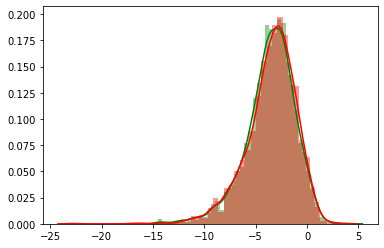

 33%|███▎      | 1/3 [00:02<00:04,  2.16s/it]

DMPNN with rdkit 2d normalized wo MolLogP   364
StructGNN with ext valence with rdkit wo fragments and counts   351
logP


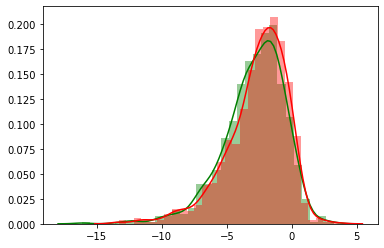

 67%|██████▋   | 2/3 [00:03<00:01,  1.91s/it]

DMPNN with rdkit 2d normalized wo MolLogP   365
StructGNN with ext valence with rdkit wo fragments and counts   352
logD


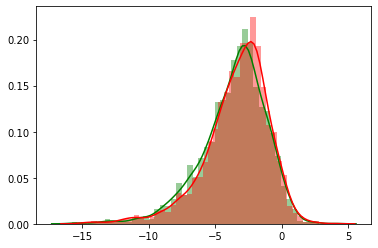

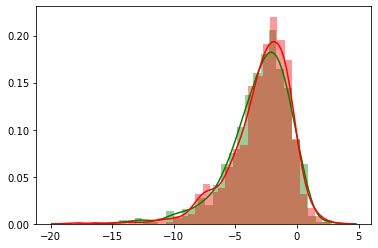

100%|██████████| 3/3 [00:06<00:00,  2.09s/it]

DMPNN with rdkit 2d normalized wo MolLogP   368
StructGNN with ext valence with rdkit wo fragments and counts   359
logP logD


In [24]:
p_values = []
for NUM_EXP_PAIR in tqdm(NUM_EXPS_PAIRS):
    p_value = {} 
    p_value_mean_std = {}
    
    NUM_EXP_1, NUM_EXP_2 = NUM_EXP_PAIR
    
    DATA_PATH_1 = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP_1)+'/folds'
    DATA_PATH_2 = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP_2)+'/folds'
    rmse = []
    
    preds = []
    
    for FOLD in range(FOLDS):
        import json
        with open(os.path.join(DATA_PATH_1,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args_1 = json.load(f)
        with open(os.path.join(DATA_PATH_2,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args_2 = json.load(f)
        VALUE_COLUMNS = args_1['target_columns']
        PRED_COLUMNS = [value+'_pred' for value in VALUE_COLUMNS]
        if args_1['additional_encoder']:
            p_value_mean_std['Model_1'] = 'StructGNN with ext valence'
        else:
            p_value_mean_std['Model_1'] = 'DMPNN'
        if args_2['additional_encoder']:
            p_value_mean_std['Model_2'] = 'StructGNN with ext valence'
        else:
            p_value_mean_std['Model_2'] = 'DMPNN'
        p_value_mean_std['Num_exp_1'] = NUM_EXP_1
        p_value_mean_std['Num_exp_2'] = NUM_EXP_2
        p_value_mean_std['Data'] = ' '.join(args_1['target_columns'])
        
        p_value_mean_std['Dataset'] = args_1['separate_test_path']

        p_value_mean_std['Model_1'] += ' with '+' '.join(args_1['features_generator'][0].split('_'))
        p_value_mean_std['Model_2'] += ' with '+' '.join(args_2['features_generator'][0].split('_'))
        
        for VALUE_COLUMN in VALUE_COLUMNS:
            if VALUE_COLUMN in p_value.keys():
                pass
            else:
                p_value[VALUE_COLUMN] = {}
                p_value[VALUE_COLUMN]['r2_1'] = []
                p_value[VALUE_COLUMN]['rmse_1'] = []
                p_value[VALUE_COLUMN]['r2_2'] = []
                p_value[VALUE_COLUMN]['rmse_2'] = []
                p_value[VALUE_COLUMN]['Shapiro_p_value_1'] = []
                p_value[VALUE_COLUMN]['Shapiro_p_value_2'] = []
                p_value[VALUE_COLUMN]['Normaltest_p_value_1'] = []
                p_value[VALUE_COLUMN]['Normaltest_p_value_2'] = []
                p_value[VALUE_COLUMN]['P_VALUE'] = []
                
            PRED_COLUMN = VALUE_COLUMN+'_pred'
            test_prediction_1 = pd.read_csv(os.path.join(DATA_PATH_1,'fold_'+str(FOLD), FILENAME))
            test_prediction_2 = pd.read_csv(os.path.join(DATA_PATH_2,'fold_'+str(FOLD), FILENAME))
            
            ERROR_COLUMN_1 = (test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][VALUE_COLUMN].values\
                                               - test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][PRED_COLUMN].values)**2
            
            ERROR_COLUMN_2 = (test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][VALUE_COLUMN].values\
                                               - test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][PRED_COLUMN].values)**2
            
            p_value[VALUE_COLUMN]['rmse_1'].append(mean_squared_error(test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            
            p_value[VALUE_COLUMN]['rmse_2'].append(mean_squared_error(test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][PRED_COLUMN])**0.5)
            
            p_value[VALUE_COLUMN]['r2_1'].append(r2_score(test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_1[~test_prediction_1[VALUE_COLUMN].isna()][PRED_COLUMN]))
            
            p_value[VALUE_COLUMN]['r2_2'].append(r2_score(test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][VALUE_COLUMN],\
                                                                     test_prediction_2[~test_prediction_2[VALUE_COLUMN].isna()][PRED_COLUMN]))
            
            
            stat, p = shapiro(ERROR_COLUMN_1)
            p_value[VALUE_COLUMN]['Shapiro_p_value_1'].append(p)
            stat, p = shapiro(ERROR_COLUMN_2)
            p_value[VALUE_COLUMN]['Shapiro_p_value_2'].append(p)
            
            stat, p = normaltest(ERROR_COLUMN_1)
            p_value[VALUE_COLUMN]['Normaltest_p_value_1'].append(p)
            stat, p = normaltest(ERROR_COLUMN_2)
            p_value[VALUE_COLUMN]['Normaltest_p_value_2'].append(p)
            
            if p_value[VALUE_COLUMN]['Shapiro_p_value_1'][-1]>ALPHA and \
            p_value[VALUE_COLUMN]['Shapiro_p_value_2'][-1]>ALPHA and \
            p_value[VALUE_COLUMN]['Normaltest_p_value_1'][-1]>ALPHA and \
            p_value[VALUE_COLUMN]['Normaltest_p_value_2'][-1]>ALPHA:
                stat, p = ttest_ind(ERROR_COLUMN_1, ERROR_COLUMN_2)
                p_value[VALUE_COLUMN]['P_VALUE'].append(p)
            else:
                if 'DMPNN' in p_value_mean_std['Model_1']:
                    stat, p = mannwhitneyu(ERROR_COLUMN_1, ERROR_COLUMN_2, alternative = 'greater')
                    p_value[VALUE_COLUMN]['P_VALUE'].append(p)
                else:
                    stat, p = mannwhitneyu(ERROR_COLUMN_1, ERROR_COLUMN_2, alternative = 'less')
                    p_value[VALUE_COLUMN]['P_VALUE'].append(p) 
                    
            if 'DMPNN' in p_value_mean_std['Model_1']:
                sns.distplot(np.log(ERROR_COLUMN_2), color='g')
                sns.distplot(np.log(ERROR_COLUMN_1), color='r')
            else:
                sns.distplot(np.log(ERROR_COLUMN_1), color='g')
                sns.distplot(np.log(ERROR_COLUMN_2), color='r')
            plt.show()

    
    for VALUE in p_value.keys():
        for stat in p_value[VALUE].keys():
            p_value_mean_std[VALUE+'_'+stat+'_mean'] = np.mean(p_value[VALUE][stat])
            p_value_mean_std[VALUE+'_'+stat+'_std'] = np.std(p_value[VALUE][stat])
            
    print(p_value_mean_std['Model_1'], ' ', str(p_value_mean_std['Num_exp_1']))
    print(p_value_mean_std['Model_2'], ' ', str(p_value_mean_std['Num_exp_2']))
    print(p_value_mean_std['Data'])
    
    
    
    
    p_values.append(p_value_mean_std)
    
p_values = pd.DataFrame(p_values)

values = {}
for column in list(p_values):
    if column not in ['Model_1','Num_exp_1','Model_2','Num_exp_2','Data','Dataset']:
        property_name = ' '.join(column.split('_')[:-1])
        value_name = column.split('_')[-1]
        value = p_values[column].values
        if property_name not in values.keys():
            values[property_name] = {}
            values[property_name][value_name] = value
        else:
            values[property_name][value_name] = value
            values[property_name] = [str(round(mean,3))+'+/-'+str(round(std, 3)) for mean, std in zip(values[property_name]['mean'], values[property_name]['std'])]
stats_markdown_table = pd.DataFrame(columns = ['Model_1',
 'Model_2',
 'Num_exp_1',
 'Num_exp_2',
 'Data',
 'logP P VALUE',
 'logD P VALUE',
 'logP rmse 1',
 'logP rmse 2',
 'logP r2 1',
 'logP r2 2',
 'logD rmse 1',
 'logD rmse 2',
 'logD r2 1',
 'logD r2 2',
 'Dataset',
 'logP Shapiro p value 1',
 'logP Shapiro p value 2',
 'logP Normaltest p value 1',
 'logP Normaltest p value 2'
 'logD Shapiro p value 1',
 'logD Shapiro p value 2',
 'logD Normaltest p value 1',
 'logD Normaltest p value 2'])
for column in p_values.keys():
    stats_markdown_table[column] = p_values[column]
for column in values.keys():
    stats_markdown_table[column] = values[column]
stats_markdown_table = stats_markdown_table[['Model_1',
 'Model_2',
 'Num_exp_1',
 'Num_exp_2',
 'Data',
 'logP P VALUE',
 'logD P VALUE',
 'logP rmse 1',
 'logP rmse 2',
 'logP r2 1',
 'logP r2 2',
 'logD rmse 1',
 'logD rmse 2',
 'logD r2 1',
 'logD r2 2',
 'Dataset']]    
RAW_PATH = '../../data/raw/baselines/dmpnn/'
with open(os.path.join(RAW_PATH, 'DMPNN_StructDNN_p_value_comparison.txt'), 'w') as f:
    f.write(stats_markdown_table.to_markdown())

In [12]:

FILENAME = "test_predictions.csv"

SMILES_COLUMN = 'smiles'

In [18]:
VALUE_COLUMN = 'logP'
PRED_COLUMN = 'logP_pred'

In [7]:
 DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(331)+'/folds'

In [10]:
DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(331)+'/folds'
test_prediction_MULTITASK = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(0), FILENAME))

In [11]:
DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(326)+'/folds'
test_prediction_logP_DMPNN = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(0), FILENAME))

In [33]:
Preds_MULTITASK  = test_prediction_MULTITASK[~test_prediction_MULTITASK[VALUE_COLUMN].isna()]
Preds_logP_DMPNN  = test_prediction_logP_DMPNN[~test_prediction_logP_DMPNN[VALUE_COLUMN].isna()]


In [34]:
Preds_MULTITASK.shape

(2095, 5)

In [35]:
Preds_logP_DMPNN.shape

(2067, 3)

In [54]:
ERROR_MULTITASK = ERROR_MULTITASK[np.where(ERROR_MULTITASK<2)]

In [61]:
ERROR_MULTITASK = (Preds_MULTITASK[VALUE_COLUMN].values - Preds_MULTITASK[PRED_COLUMN].values)**2
print('Multitask error = ', np.sqrt(np.mean(ERROR_MULTITASK)))
ERROR_DMPNN = (Preds_logP_DMPNN[VALUE_COLUMN].values-Preds_logP_DMPNN[PRED_COLUMN].values)**2
print('DMPNN error = ', np.sqrt(np.mean(ERROR_DMPNN)))

Multitask error =  0.4157461049247995
DMPNN error =  0.4503919784984623


In [62]:
Q_MULTITASK = np.quantile(ERROR_MULTITASK,[0.25,0.75])
ERROR_MULTITASK = ERROR_MULTITASK[np.where(ERROR_MULTITASK>Q_MULTITASK[0])]
ERROR_MULTITASK = ERROR_MULTITASK[np.where(ERROR_MULTITASK<Q_MULTITASK[1])]


Q_DMPNN = np.quantile(ERROR_DMPNN,[0.25,0.75])
ERROR_DMPNN = ERROR_DMPNN[np.where(ERROR_DMPNN>Q_DMPNN[0])]
ERROR_DMPNN = ERROR_DMPNN[np.where(ERROR_DMPNN<Q_DMPNN[1])]

<AxesSubplot:>

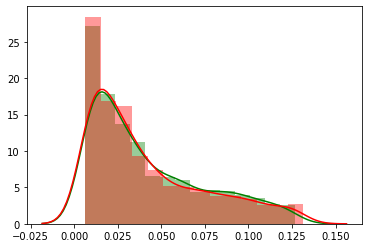

In [64]:
sns.distplot(ERROR_MULTITASK, color='g')
sns.distplot(ERROR_DMPNN, color='r')

In [65]:
stat, p = shapiro(ERROR_MULTITASK)
print('MultiTask Normaltest pvalue = ', p)
stat, p = shapiro(ERROR_DMPNN)
print('DMPNN Normaltest pvalue = ', p)

MultiTask Normaltest pvalue =  1.5944149045314972e-27
DMPNN Normaltest pvalue =  1.0063785025909551e-28


In [71]:
stat, p = mannwhitneyu(ERROR_MULTITASK, ERROR_DMPNN, alternative = 'less')
print('Errors p-value ', p)

Errors p-value  0.7756001772628621


In [32]:
stat, p = mannwhitneyu(ERROR_MULTITASK, np.ones((100000, )), alternative = 'greater')

# Calculate correlation between logD and logP predictions in multitask

In [24]:
NUM_EXPS= [317]

In [37]:
correlation_mean_std = {}
correlation_mean_std['Pearson\'s r'] = {}
correlation_mean_std['Spearman\'s rho'] = {}
correlation_mean_std['Kendall\'s tau'] = {}
for NUM_EXP in tqdm(NUM_EXPS):
    DATA_PATH = "../../data/raw/baselines/dmpnn/logs/exp_"+str(NUM_EXP)+'/folds'
    rmse = []
    
    correlation = {}
    correlation['Pearson\'s r'] = []
    correlation['Spearman\'s rho'] = []
    correlation['Kendall\'s tau'] = []

    for FOLD in range(FOLDS):
        import json
        with open(os.path.join(DATA_PATH,'fold_'+str(FOLD), 'args.json'), 'r') as f:
            args = json.load(f)
        VALUE_COLUMNS = args['target_columns']
        PRED_COLUMNS = [value+'_pred' for value in args['target_columns']]
        
        test_prediction = pd.read_csv(os.path.join(DATA_PATH,'fold_'+str(FOLD), FILENAME))
        preds_0 = test_prediction[PRED_COLUMNS[0]]
        preds_1 = test_prediction[PRED_COLUMNS[1]]
        smiles = test_prediction[~test_prediction[VALUE_COLUMN].isna()][SMILES_COLUMN]
        values = test_prediction[~test_prediction[VALUE_COLUMN].isna()][VALUE_COLUMN]


        correlation['Pearson\'s r'].append(preds_0.corr(preds_1))
        correlation['Spearman\'s rho'].append(preds_0.corr(preds_1, method='spearman'))
        correlation['Kendall\'s tau'].append(preds_0.corr(preds_1, method='kendall'))
        
for method in correlation.keys():
    correlation_mean_std[method]['mean'] = np.mean(correlation[method])
    correlation_mean_std[method]['std'] = np.std(correlation[method])
    
for method in correlation_mean_std.keys():
    print(method, ' correlation = ', \
          round(correlation_mean_std[method]['mean'], 3)\
          ,'+/-',\
          round(correlation_mean_std[method]['std'], 3))

100%|██████████| 1/1 [00:00<00:00, 20.66it/s]

Pearson's r  correlation =  0.802 +/- 0.014
Spearman's rho  correlation =  0.859 +/- 0.004
Kendall's tau  correlation =  0.688 +/- 0.006
